In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

# EDA

explenation features:  
  
Pclass: 1 = First class 2 = Second class 3 = Third class  
SibSp: Number of siblings  
Parch: Number of Parents/Children Aboard  
Embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)  

In [3]:
df = pd.read_csv("titanic_correct.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Dropping the name, ticket, cabin and because they are not needed
df_cleaned = df.drop(columns=['Name', 'Ticket', 'Cabin', 'PassengerId'])
df_cleaned.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [5]:
df_cleaned.info()
print(df_cleaned.isnull().sum())
# in Age and Embarked are missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [6]:
# Impute missing Age values with the median age
df_cleaned['Age'].fillna(df_cleaned['Age'].median(), inplace=True)

# Impute missing Embarked values with the mode (most frequent value)
df_cleaned['Embarked'].fillna(df_cleaned['Embarked'].mode()[0], inplace=True)

print(df_cleaned.isnull().sum()) 
df_cleaned.head()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [7]:
#Encoding data
df_encoded = df_cleaned.copy()
df_encoded = pd.get_dummies(df_encoded,columns=['Sex'], drop_first=True)
df_encoded = pd.get_dummies(df_encoded,columns=['Embarked'])
df_encoded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,0,1
1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,26.0,0,0,7.9250,0,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,0,1


# Model

In [8]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(df_encoded, test_size=0.2, random_state=42, stratify=df_encoded['Survived'])

In [9]:
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['Survived'])

In [10]:
print(train.shape)
print(test.shape)
print(validate.shape)
test.head()

(712, 10)
(89, 10)
(90, 10)


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
799,0,3,30.0,1,1,24.1500,0,0,0,1
397,0,2,46.0,0,0,26.0000,1,0,0,1
614,0,3,35.0,0,0,8.0500,1,0,0,1
428,0,3,28.0,0,0,7.7500,1,0,1,0
485,0,3,28.0,3,1,25.4667,0,0,0,1


In [11]:
print(train['Survived'].value_counts())
print(test['Survived'].value_counts())
print(validate['Survived'].value_counts())

0    439
1    273
Name: Survived, dtype: int64
0    55
1    34
Name: Survived, dtype: int64
0    55
1    35
Name: Survived, dtype: int64


In [12]:
bucket='c135194a3427174l8479816t1w8517251742-sandboxbucket-wpdsinwea6de'

prefix='titanic'

train_file='train.csv'
test_file='test.csv'
validate_file='validate.csv'

import os

s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [13]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

# train the model

In [14]:
import boto3
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [15]:
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [16]:
import sagemaker
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [17]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [18]:
xgb_model.fit(inputs=data_channels, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-23-07-53-38-305



2024-11-23 07:53:39 Starting - Starting the training job..
2024-11-23 07:53:54 Starting - Preparing the instances for training.......
2024-11-23 07:54:35 Downloading - Downloading input data.......
2024-11-23 07:55:16 Downloading - Downloading the training image.......
2024-11-23 07:55:57 Training - Training image download completed. Training in progress....
2024-11-23 07:56:17 Uploading - Uploading generated training model..
2024-11-23 07:56:31 Completed - Training job completed


# hosting the model

In [19]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-23-08-09-04-984
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-23-08-09-04-984
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-23-08-09-04-984


------!

# performing predictions

In [21]:
test.shape

(89, 10)

In [22]:
test.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
799,0,3,30.0,1,1,24.1500,0,0,0,1
397,0,2,46.0,0,0,26.0000,1,0,0,1
614,0,3,35.0,0,0,8.0500,1,0,0,1
428,0,3,28.0,0,0,7.7500,1,0,1,0
485,0,3,28.0,3,1,25.4667,0,0,0,1


In [23]:
row = test.iloc[0:1,1:]
row.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
799,3,30.0,1,1,24.15,0,0,0,1


In [24]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

3,30.0,1,1,24.15,0,0,0,1



In [25]:
xgb_predictor.predict(test_row)

b'0.15283922851085663'

In [26]:
test.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
799,0,3,30.0,1,1,24.1500,0,0,0,1
397,0,2,46.0,0,0,26.0000,1,0,0,1
614,0,3,35.0,0,0,8.0500,1,0,0,1
428,0,3,28.0,0,0,7.7500,1,0,1,0
485,0,3,28.0,3,1,25.4667,0,0,0,1


# terminating the deployed model

In [27]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-11-23-08-09-04-984
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-11-23-08-09-04-984


# performing a batch transform

In [28]:
batch_X = test.iloc[:,1:];
batch_X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
799,3,30.0,1,1,24.1500,0,0,0,1
397,2,46.0,0,0,26.0000,1,0,0,1
614,3,35.0,0,0,8.0500,1,0,0,1
428,3,28.0,0,0,7.7500,1,0,1,0
485,3,28.0,3,1,25.4667,0,0,0,1


In [29]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [30]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-23-08-20-27-628
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-23-08-20-28-295


............................................[2024-11-23:08:27:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-23:08:27:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-23:08:27:44:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
[2024-11-23:08:27:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-23:08:27:44:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-23:08:27:44:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(pi

In [51]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['Survived'])
target_predicted.head(5)

,Survived
0,0.152839
1,0.041669
2,0.093111
3,0.335455
4,0.049019


In [303]:
def binary_convert(x):
    threshold = 0.37
    if x > threshold:
        return 1
    else:
        return 0

target_predicted['binary'] = target_predicted['Survived'].apply(binary_convert)

print(target_predicted.head(10))
test.head(10)

   Survived  binary
0  0.152839       0
1  0.041669       0
2  0.093111       0
3  0.335455       0
4  0.049019       0
5  0.215811       0
6  0.099848       0
7  0.161607       0
8  0.027123       0
9  0.053898       0


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
799,0,3,30.0,1,1,24.1500,0,0,0,1
397,0,2,46.0,0,0,26.0000,1,0,0,1
614,0,3,35.0,0,0,8.0500,1,0,0,1
428,0,3,28.0,0,0,7.7500,1,0,1,0
485,0,3,28.0,3,1,25.4667,0,0,0,1
452,0,1,30.0,0,0,27.7500,1,1,0,0
495,0,3,28.0,0,0,14.4583,1,1,0,0
764,0,3,16.0,0,0,7.7750,1,0,0,1
864,0,2,24.0,0,0,13.0000,1,0,0,1
565,0,3,24.0,2,0,24.1500,1,0,0,1


# confusion matrix

In [304]:
test_labels = test.iloc[:,0]
test_labels.head()

799    0
397    0
614    0
428    0
485    0
Name: Survived, dtype: int64

In [305]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, target_predicted['binary'])
df_confusion = pd.DataFrame(matrix, index=['Not survived','Survived'],columns=['Not survived','Survived'])

df_confusion

,Not survived,Survived
Not survived,49,6
Survived,8,26


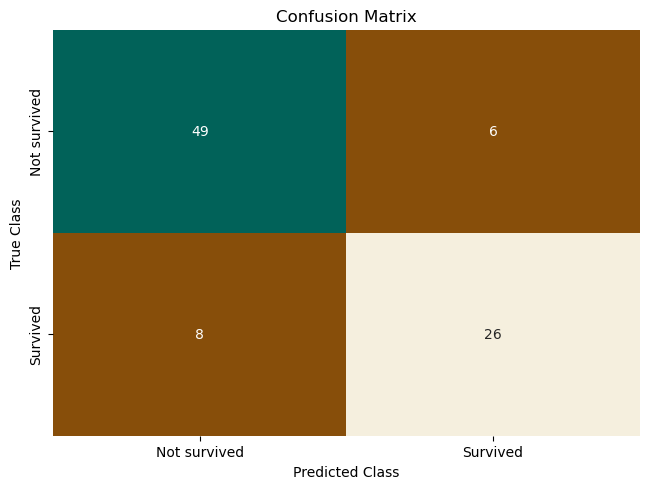

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt

colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

# calculating performance statistic

In [307]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted['binary']).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 49
False Positive (FP): 6
False Negative (FN): 8
True Positive (TP) : 26


In [308]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {round(Sensitivity)}% chance of detecting passenger who survived are alive.")

Sensitivity or TPR: 76.47058823529412%
There is a 76% chance of detecting passenger who survived are alive.


In [309]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {round(Specificity)}% chance of detecting passengers who didn't survive are dead.")


Specificity or TNR: 89.0909090909091%
There is a 89% chance of detecting passengers who didn't survive are dead.


In [310]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You survived, and the probablity that is correct is {round(Precision)}%.")

Precision: 81.25%
You survived, and the probablity that is correct is 81%.


In [311]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You didn't survive, but there is a {round(NPV)}% chance that is incorrect." )

Negative Predictive Value: 85.96491228070175%
You didn't survive, but there is a 86% chance that is incorrect.


In [312]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {round(FPR)}% chance that this positive result is incorrect.")

False Positive Rate: 10.909090909090908%
There is a 11% chance that this positive result is incorrect.


In [313]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {round(FNR)}% chance that this negative result is incorrect.")

False Negative Rate: 23.52941176470588%
There is a 24% chance that this negative result is incorrect.


In [314]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You survived, but there is a {round(FDR)}% chance this is incorrect.")

False Discovery Rate: 18.75%
You survived, but there is a 19% chance this is incorrect.


In [315]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 84.26966292134831%


In [316]:
print(f"Sensitivity or TPR: {round(Sensitivity)}%")    
print(f"Specificity or TNR: {round(Specificity)}%") 
print(f"Precision: {round(Precision)}%")   
print(f"Negative Predictive Value: {round(NPV)}%")  
print( f"False Positive Rate: {round(FPR)}%") 
print(f"False Negative Rate: {round(FNR)}%")  
print(f"False Discovery Rate: {round(FDR)}%" )
print(f"Accuracy: {round(ACC)}%") 

Sensitivity or TPR: 76%
Specificity or TNR: 89%
Precision: 81%
Negative Predictive Value: 86%
False Positive Rate: 11%
False Negative Rate: 24%
False Discovery Rate: 19%
Accuracy: 84%


# calculating AUC-ROC curve

In [321]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted['binary']) )

Validation AUC 0.827807486631016


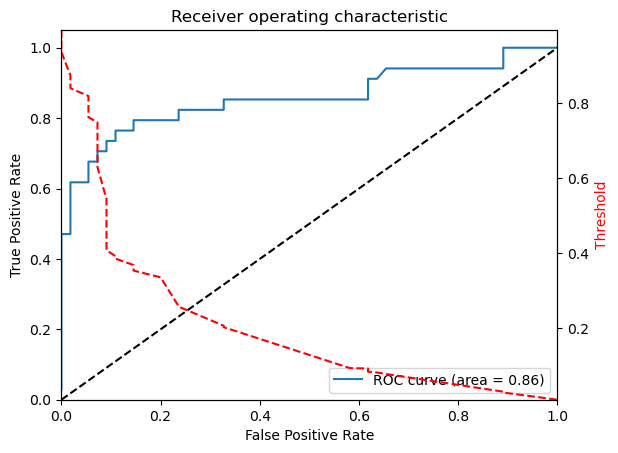

In [322]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['Survived'])

finite_indices = np.isfinite(thresholds) 
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(fpr_finite, tpr_finite, label='ROC curve (area = %0.2f)' % auc(fpr_finite, tpr_finite))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(fpr_finite, thresholds_finite, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()

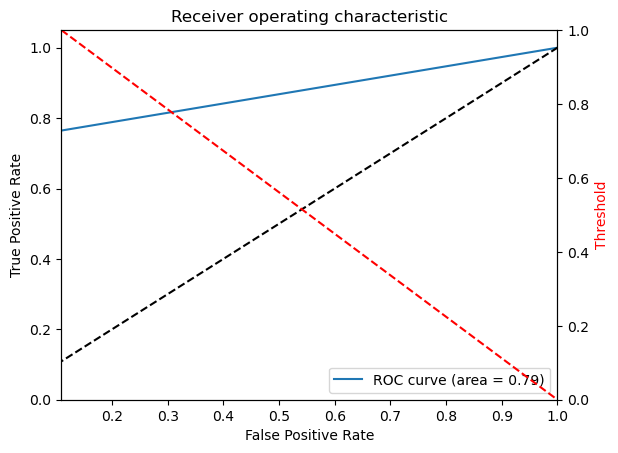

In [320]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted['binary'])

finite_indices = np.isfinite(thresholds) 
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(fpr_finite, tpr_finite, label='ROC curve (area = %0.2f)' % auc(fpr_finite, tpr_finite))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(fpr_finite, thresholds_finite, markeredgecolor='r', linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold', color='r')
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()

# create hyperparameter tuning job

In [323]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-241123-0959


...............................................................................................................................................!
!
CPU times: user 829 ms, sys: 88 ms, total: 917 ms
Wall time: 12min 21s


In [324]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

# investigateting the tuning job results

In [325]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,22.405320,0.250714,3.859192,12.0,0.999794,sagemaker-xgboost-241123-0959-009-f3ab8a7d,Completed,0.20000,2024-11-23 10:10:23+00:00,2024-11-23 10:10:57+00:00,34.0
2,21.476449,0.283766,1.016743,9.0,0.620498,sagemaker-xgboost-241123-0959-008-3570fbd2,Completed,0.20000,2024-11-23 10:09:29+00:00,2024-11-23 10:09:59+00:00,30.0
8,23.273261,0.113269,2.758633,7.0,0.651648,sagemaker-xgboost-241123-0959-002-13cb0648,Completed,0.20000,2024-11-23 10:02:32+00:00,2024-11-23 10:03:01+00:00,29.0
9,19.815592,0.197190,1.296762,12.0,0.773391,sagemaker-xgboost-241123-0959-001-e7288f16,Completed,0.20000,2024-11-23 10:00:24+00:00,2024-11-23 10:02:14+00:00,110.0
3,11.928399,0.282274,1.356173,15.0,0.865529,sagemaker-xgboost-241123-0959-007-f5442c6c,Completed,0.21111,2024-11-23 10:08:18+00:00,2024-11-23 10:08:47+00:00,29.0
0,30.193662,0.172407,1.601165,35.0,0.565961,sagemaker-xgboost-241123-0959-010-40e8bb39,Stopped,0.23333,2024-11-23 10:11:14+00:00,2024-11-23 10:11:45+00:00,31.0
7,41.239536,0.204901,2.397474,34.0,0.671230,sagemaker-xgboost-241123-0959-003-4d3e2a15,Completed,0.23333,2024-11-23 10:03:11+00:00,2024-11-23 10:03:39+00:00,28.0
4,0.000000,0.180793,3.878439,36.0,0.687383,sagemaker-xgboost-241123-0959-006-4715ae19,Completed,0.24444,2024-11-23 10:07:25+00:00,2024-11-23 10:07:59+00:00,34.0
5,85.653068,0.139089,3.794839,43.0,0.992112,sagemaker-xgboost-241123-0959-005-d80a3024,Completed,0.38889,2024-11-23 10:05:03+00:00,2024-11-23 10:06:53+00:00,110.0
6,92.571288,0.292651,4.954165,28.0,0.894768,sagemaker-xgboost-241123-0959-004-16d179e7,Stopped,0.38889,2024-11-23 10:03:51+00:00,2024-11-23 10:04:16+00:00,25.0


In [326]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [327]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2024-11-23 10:02:30 Starting - Preparing the instances for training
2024-11-23 10:02:30 Downloading - Downloading the training image
2024-11-23 10:02:30 Training - Training image download completed. Training in progress.
2024-11-23 10:02:30 Uploading - Uploading generated training model
2024-11-23 10:02:30 Completed - Resource reused by training job: sagemaker-xgboost-241123-0959-002-13cb0648


In [328]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-23-10-16-23-989
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-23-10-16-24-699


........................................[2024-11-23:10:23:02:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-23:10:23:02:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-23:10:23:02:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-23:10:23:02:INFO] No GPUs detected 

In [330]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),names=['class'])

def binary_convert(x):
    threshold = 0.37
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

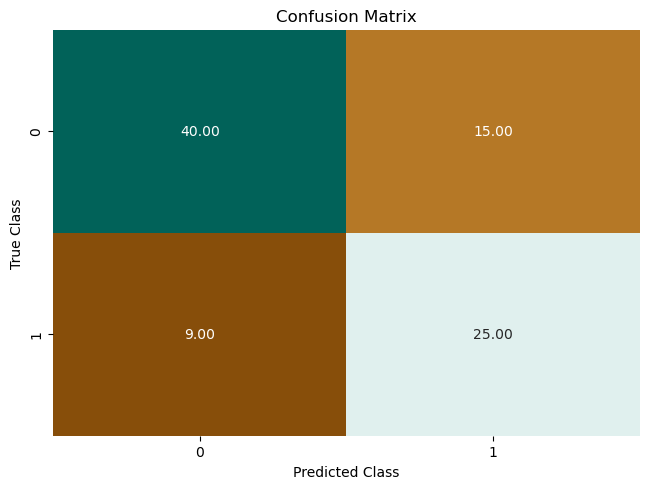

In [332]:
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()


plot_confusion_matrix(test_labels, best_target_predicted_binary)

In [335]:
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

plot_roc(test_labels, best_target_predicted_binary)